# CMIP6-derived aerosol forcing coefficients

In [1]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import warnings
import glob
import h5py
import json
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.stats import gaussian_kde
from fair.constants import molwt
import matplotlib.gridspec as gridspec
from ar6.utils import check_and_download
from ar6.forcing.aerosol import aerocom_n, ghan

In [2]:
SAMPLES = 100000

In [3]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 8
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['xtick.direction'] = 'in'
pl.rcParams['ytick.direction'] = 'in'
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

In [4]:
warnings.simplefilter('ignore')

In [5]:
cubes = {}
models = ['CanESM5', 'E3SM', 'GFDL-ESM4', 'GFDL-CM4', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'NorESM2-LM', 'UKESM1-0-LL']

endyear = {
    'CanESM5'    : 2100,
    'MIROC6'     : 2100,
    'NorESM2-LM' : 2014,
    'GISS-E2-1-G': 2100,
    'HadGEM3-GC31-LL': 2099,
    'GFDL-CM4'   : 2100,
    'E3SM'       : 2014,
    'UKESM1-0-LL': 2014,
    'GFDL-ESM4'  : 2014,
    'IPSL-CM6A-LR': 2100,
    'MRI-ESM2-0' : 2014,
}

startyear = {
    'CanESM5'    : 1850,
    'MIROC6'     : 1850,
    'NorESM2-LM' : 1850,
    'GISS-E2-1-G': 1850,
    'HadGEM3-GC31-LL': 1850,
    'GFDL-CM4'   : 1850,
    'E3SM'       : 1870,
    'GFDL-ESM4'  : 1850,
    'UKESM1-0-LL': 1850,
    'IPSL-CM6A-LR': 1850,
    'MRI-ESM2-0': 1850,
}

In [6]:
colors = {
    'CanESM5'    :  'red',#'#1e4c24',
    'E3SM'       : 'darkorange',
    'GFDL-ESM4'  : 'yellow', 
    'GFDL-CM4'   : 'yellowgreen',#'green',
    'GISS-E2-1-G':  'green',#'#771d7b',
    'HadGEM3-GC31-LL': 'turquoise',
    'IPSL-CM6A-LR': 'teal',
    'MIROC6'     :  'blue',#b85fb7',
    'MRI-ESM2-0' : 'blueviolet',
    'NorESM2-LM' :  'purple',#'red',
    'UKESM1-0-LL': 'crimson',
    'mean'       : 'black',
    'AR5'         : '0.6',
    'AR6'         : '0.3',
    'Lund'        : 'pink',
}

In [7]:
cubes = {}

for model in models:
    cubes[model] =  pd.read_csv('../data_input/%s.csv' % model)  # will change when full process on GitHub
    cubes[model].set_index('year', inplace=True)
cubes['CanESM5']

,erf,erf_sw,erf_lw,aprp_ERFariSW,aprp_ERFaciSW,aprp_ERFariLW,aprp_ERFaciLW,aprp_albedo,aprp_t9
year,,,,,,,,,
1850.5,-0.056411,-0.012546,-0.043865,-0.038897,0.026163,-0.071697,0.027832,-0.006923,0.005664
1851.5,0.002193,-0.010708,0.012901,-0.012279,0.011233,-0.022048,0.034949,-0.000776,-0.026092
1852.5,0.040748,-0.027904,0.068653,0.004813,-0.007301,0.046973,0.021680,-0.011223,-0.047048
1853.5,0.011026,-0.003637,0.014663,0.002971,0.007722,-0.018817,0.033479,-0.008680,-0.093939
1854.5,-0.068579,0.026503,-0.095081,0.043915,0.002132,-0.105349,0.010268,0.000403,0.039951
...,...,...,...,...,...,...,...,...,...
2096.5,-0.503850,-0.555937,0.052087,-0.097492,-0.440797,0.044686,0.007402,-0.013595,-0.076017
2097.5,-0.510893,-0.598792,0.087899,-0.121421,-0.430272,0.109054,-0.021155,-0.015885,-0.040576
2098.5,-0.353960,-0.481014,0.127054,-0.087114,-0.372218,0.098973,0.028081,0.006737,-0.075541


In [8]:
check_and_download(
    '../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv',
    'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-emissions-annual-means-v5-1-0.csv'
)
    
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')

In [9]:
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None
emissions

,SO2,BC,OC,NH3,NOx
year,,,,,
1750,2.440048,2.097771,15.447668,6.927690,12.735212
1751,2.408379,2.072926,15.188717,6.860142,12.592303
1752,2.397116,2.064312,15.034476,6.819482,12.594270
1753,2.410693,2.071951,15.182545,6.881439,12.539820
1754,2.462065,2.099350,15.558773,7.015189,12.636837
...,...,...,...,...,...
2096,31.757785,2.800165,15.001741,66.175403,79.831397
2097,31.523938,2.762863,14.886222,65.973947,79.296580
2098,31.290090,2.725561,14.770703,65.772490,78.761762


In [10]:
coeff = {}

for model in models:
    coeff[model] = {}

    coeff[model]['ERFari'] = {}
    p, cov = curve_fit(
        aerocom_n, 
        [
            emissions.loc[str(startyear[model]):str(endyear[model]), 'BC'].values.T-emissions.loc['1850':'1850', 'BC'].values.T,
            emissions.loc[str(startyear[model]):str(endyear[model]), 'OC'].values.T-emissions.loc['1850':'1850', 'OC'].values.T,
            emissions.loc[str(startyear[model]):str(endyear[model]), 'SO2'].values.T-emissions.loc['1850':'1850', 'SO2'].values.T,
            (
                1.0*emissions.loc[str(startyear[model]):str(endyear[model]), 'NH3'].values.T-emissions.loc['1850':'1850', 'NH3'].values.T+
                0.0*emissions.loc[str(startyear[model]):str(endyear[model]), 'NOx'].values.T-emissions.loc['1850':'1850', 'NOx'].values.T
            ),
        ],
        cubes[model]['aprp_ERFariSW']+cubes[model]['aprp_ERFariLW'],
        bounds = ((0, -np.inf, -np.inf, -np.inf), (np.inf, np.inf, 0, 0))
    )
    coeff[model]['ERFari']['BC'] = p[0]
    coeff[model]['ERFari']['OC'] = p[1]
    coeff[model]['ERFari']['SO2'] = p[2]
    coeff[model]['ERFari']['NH3'] = p[3]


    coeff[model]['ERFaci'] = {}
    p, cov = curve_fit(
        ghan, 
        [
            emissions.loc[str(startyear[model]):str(endyear[model]), 'SO2'].values.T-emissions.loc['1850':'1850', 'SO2'].values.T,
            (
                emissions.loc[str(startyear[model]):str(endyear[model]), 'BC'].values.T-emissions.loc['1850':'1850', 'BC'].values.T+
                emissions.loc[str(startyear[model]):str(endyear[model]), 'OC'].values.T-emissions.loc['1850':'1850', 'OC'].values.T
            ),
        ],
        cubes[model]['aprp_ERFaciSW']+cubes[model]['aprp_ERFaciLW'],#-cubes[model]['aprp_ERFariSW'],
        bounds = ((0, 0, 0), (np.inf, np.inf, np.inf))
    )
    coeff[model]['ERFaci']['beta'] = p[0]
    coeff[model]['ERFaci']['n0']   = p[1]
    coeff[model]['ERFaci']['n1']   = p[2]

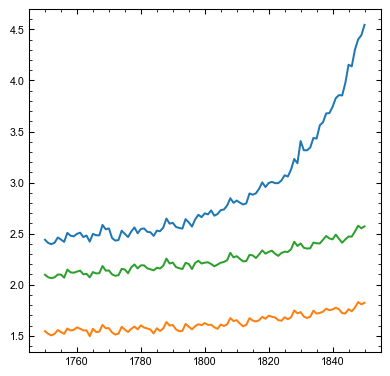

In [11]:
pl.plot(emissions.loc[1750:1850, 'SO2'])
pl.plot(emissions.loc[1750:1850, 'OC']/10)
pl.plot(emissions.loc[1750:1850, 'BC'])

In [12]:
emulated = {}
for model in models:
    emulated[model] = {}
    emulated[model]['ERFari'] = aerocom_n([
        emissions.loc['1750':'2100', 'BC'].values.T-emissions.loc['1850':'1850', 'BC'].values.T,
        emissions.loc['1750':'2100', 'OC'].values.T-emissions.loc['1850':'1850', 'OC'].values.T,
        emissions.loc['1750':'2100', 'SO2'].values.T-emissions.loc['1850':'1850', 'SO2'].values.T,
            1.0*(emissions.loc['1750':'2100', 'NH3'].values.T-emissions.loc['1850':'1850', 'NH3'].values.T)+
            0.0*(emissions.loc['1750':'2100', 'NOx'].values.T-emissions.loc['1850':'1850', 'NOx'].values.T),
        #emissions.loc['1750':'2100', ['BC','OC','SO2','NH3']].values.T-emissions.loc['1850':'1850', ['BC','OC','SO2','NH3']].values.T,
    ], coeff[model]['ERFari']['BC'], coeff[model]['ERFari']['OC'], coeff[model]['ERFari']['SO2'], coeff[model]['ERFari']['NH3'])
    emulated[model]['ERFaci'] = ghan([
        emissions.loc['1750':'2100', 'SO2'].values.T-emissions.loc['1850':'1850', 'SO2'].values.T,
        emissions.loc['1750':'2100', ['BC','OC']].sum(axis=1).values.T-emissions.loc['1850':'1850', ['BC','OC']].sum(axis=1).values.T,
    ], coeff[model]['ERFaci']['beta'], coeff[model]['ERFaci']['n0'], coeff[model]['ERFaci']['n1'])

In [13]:
emulated['mean'] = {}
nmodels = len(models)
for quantity in ['ERFari', 'ERFaci']:
    tally = np.zeros((351))
    for i, model in enumerate(models):
        tally = tally + emulated[model][quantity]
    emulated['mean'][quantity] = tally/nmodels

In [14]:
coeff['mean'] = {}

coeff['mean']['ERFari'] = {}
p, cov = curve_fit(
    aerocom_n, 
        [
            emissions.loc['1850':'2100', 'BC'].values.T-emissions.loc['1850':'1850', 'BC'].values.T,
            emissions.loc['1850':'2100', 'OC'].values.T-emissions.loc['1850':'1850', 'OC'].values.T,
            emissions.loc['1850':'2100', 'SO2'].values.T-emissions.loc['1850':'1850', 'SO2'].values.T,
            (
                1.0*emissions.loc['1850':'2100', 'NH3'].values.T-emissions.loc['1850':'1850', 'NH3'].values.T+
                0.0*emissions.loc['1850':'2100', 'NOx'].values.T-emissions.loc['1850':'1850', 'NOx'].values.T
            ),
        ],
    emulated['mean']['ERFari'][100:],
    bounds = ((0, -np.inf, -np.inf, -np.inf), (np.inf, np.inf, 0, 0))
)
coeff['mean']['ERFari']['BC'] = p[0]
coeff['mean']['ERFari']['OC'] = p[1]
coeff['mean']['ERFari']['SO2'] = p[2]
coeff['mean']['ERFari']['NH3'] = p[3]

coeff['mean']['ERFaci'] = {}
p, cov = curve_fit(
    ghan, 
        [
            emissions.loc['1850':'2100', 'SO2'].values.T-emissions.loc['1850':'1850', 'SO2'].values.T,
            (
                emissions.loc['1850':'2100', 'BC'].values.T-emissions.loc['1850':'1850', 'BC'].values.T+
                emissions.loc['1850':'2100', 'OC'].values.T-emissions.loc['1850':'1850', 'OC'].values.T
            ),
        ],
        emulated['mean']['ERFaci'][100:],
        bounds = ((0, 0, 0), (np.inf, np.inf, np.inf))
)
coeff['mean']['ERFaci']['beta'] = p[0]
coeff['mean']['ERFaci']['n0']   = p[1]
coeff['mean']['ERFaci']['n1']   = p[2]

In [15]:
emulated['mean_emulation'] = {}
emulated['mean_emulation']['ERFari'] = aerocom_n([
        emissions.loc['1750':'2100', 'BC'].values.T-emissions.loc['1850':'1850', 'BC'].values.T,
        emissions.loc['1750':'2100', 'OC'].values.T-emissions.loc['1850':'1850', 'OC'].values.T,
        emissions.loc['1750':'2100', 'SO2'].values.T-emissions.loc['1850':'1850', 'SO2'].values.T,
            1.0*(emissions.loc['1750':'2100', 'NH3'].values.T-emissions.loc['1850':'1850', 'NH3'].values.T)+
            0.0*(emissions.loc['1750':'2100', 'NOx'].values.T-emissions.loc['1850':'1850', 'NOx'].values.T),
    ], coeff['mean']['ERFari']['BC'], coeff['mean']['ERFari']['OC'], coeff['mean']['ERFari']['SO2'], coeff['mean']['ERFari']['NH3'])
emulated['mean_emulation']['ERFaci'] = ghan([
    emissions.loc['1750':'2100', 'SO2'].values.T-emissions.loc['1850':'1850', 'SO2'].values.T, 
    emissions.loc['1750':'2100', ['BC','OC']].sum(axis=1).values.T-emissions.loc['1850':'1850', ['BC','OC']].sum(axis=1).values.T,
], coeff['mean']['ERFaci']['beta'], coeff['mean']['ERFaci']['n0'], coeff['mean']['ERFaci']['n1'])

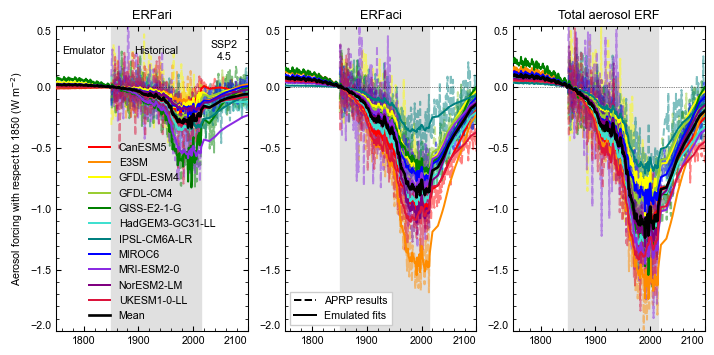

In [16]:
fig, ax = pl.subplots(1,3,figsize=(19/2.54,9.5/2.54), squeeze=False)
for model in models:
    ax[0,0].set_title('ERFari')
    ax[0,0].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFariSW'] + cubes[model]['aprp_ERFariLW'], color=colors[model], ls='--', alpha=0.5)
    ax[0,0].plot(np.arange(1750,2101), emulated[model]['ERFari'], color=colors[model], label=model, zorder=7)
    ax[0,1].set_title('ERFaci')
    ax[0,1].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFaciSW']+cubes[model]['aprp_ERFaciLW'], 
                 color=colors[model], ls='--', alpha=0.5)
    ax[0,1].plot(np.arange(1750,2101), emulated[model]['ERFaci'], color=colors[model], zorder=7)
    ax[0,2].set_title('Total aerosol ERF')
    ax[0,2].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFariSW']+cubes[model]['aprp_ERFaciSW']+cubes[model]['aprp_ERFariLW']+cubes[model]['aprp_ERFaciLW'], 
                 color=colors[model], ls='--', alpha=0.5)
    ax[0,2].plot(np.arange(1750,2101), emulated[model]['ERFari']+emulated[model]['ERFaci'], color=colors[model], zorder=7)
ax[0,0].plot(np.arange(1750,2101), emulated['mean']['ERFari'], color=colors['mean'], label='Mean', lw=2, zorder=7)
ax[0,1].plot(np.arange(1750,2101), emulated['mean']['ERFaci'], color=colors['mean'], lw=2, zorder=7)
ax[0,2].plot(np.arange(1750,2101), emulated['mean']['ERFari']+emulated['mean']['ERFaci'], color=colors['mean'], lw=2, zorder=7)
ax[0,0].set_xlim(1750,2100)
ax[0,1].set_xlim(1750,2100)
ax[0,2].set_xlim(1750,2100)
ax[0,0].set_ylabel('Aerosol forcing with respect to 1850 (W m$^{-2}$)')
#ax[0,1].set_ylabel('ERFaci with respect to 1850')
ax[0,0].legend(framealpha=1, loc='lower center', fancybox=False, frameon=False)
ax[0,0].set_ylim(-2.0, 0.5)
ax[0,1].set_ylim(-2.0, 0.5)
ax[0,2].set_ylim(-2.0, 0.5)

ax[0,0].axhline(0, lw=0.5, ls=':', color='k')
ax[0,1].axhline(0, lw=0.5, ls=':', color='k')
ax[0,2].axhline(0, lw=0.5, ls=':', color='k')
#ax[0,0].axvline(2014.5, lw=0.5, color='#c0c0c0')
ax[0,0].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
ax[0,1].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
ax[0,2].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)

ax[0,0].text(1800, 0.3, 'Emulator', ha='center', va='center')
ax[0,0].text(0.5*(1850+2015), 0.3, 'Historical', ha='center', va='center')
ax[0,0].text(0.5*(2015+2100), 0.3, 'SSP2\n4.5', ha='center', va='center')


#ax[0,0].set_xticks(np.arange(1750,2101,50))
ax[0,0].get_xticklabels()[-1].set_ha("right")
ax[0,1].get_xticklabels()[-1].set_ha("right")
ax[0,2].get_xticklabels()[-1].set_ha("right")

ax[0,0].get_yticklabels()[-1].set_va("top")
ax[0,1].get_yticklabels()[-1].set_va("top")
ax[0,2].get_yticklabels()[-1].set_va("top")

ax[0,0].get_yticklabels()[0].set_va("bottom")
ax[0,1].get_yticklabels()[0].set_va("bottom")
ax[0,2].get_yticklabels()[0].set_va("bottom")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', ls='--'),
                Line2D([0], [0], color='k', ls='-')]

ax[0,1].legend(custom_lines, ['APRP results', 'Emulated fits'], framealpha=1, loc='lower left', fancybox=False)
fig.tight_layout()

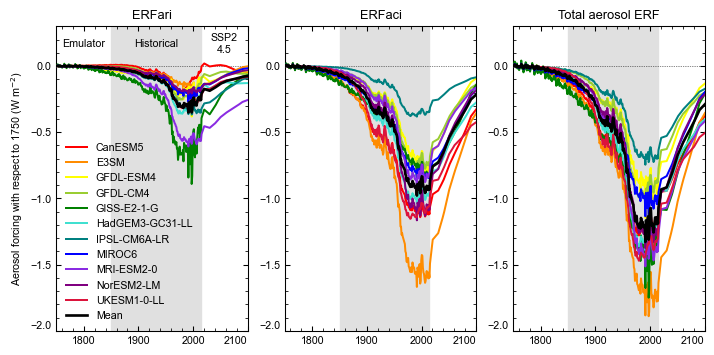

In [17]:
fig, ax = pl.subplots(1,3,figsize=(19/2.54,9.5/2.54), squeeze=False)
for model in models:
    ax[0,0].set_title('ERFari')
    ax[0,0].plot(np.arange(1750.5,2101), emulated[model]['ERFari']-emulated[model]['ERFari'][0], color=colors[model], label=model, zorder=7)
    ax[0,1].set_title('ERFaci')
    ax[0,1].plot(np.arange(1750.5,2101), emulated[model]['ERFaci']-emulated[model]['ERFaci'][0], color=colors[model], zorder=7)
    ax[0,2].set_title('Total aerosol ERF')
    ax[0,2].plot(np.arange(1750.5,2101), emulated[model]['ERFari']+emulated[model]['ERFaci']-(emulated[model]['ERFari']+emulated[model]['ERFaci'])[0], color=colors[model], zorder=7)
ax[0,0].plot(np.arange(1750.5,2101), emulated['mean']['ERFari']-emulated['mean']['ERFari'][0], color=colors['mean'], label='Mean', lw=2, zorder=7)
ax[0,1].plot(np.arange(1750.5,2101), emulated['mean']['ERFaci']-emulated['mean']['ERFaci'][0], color=colors['mean'], lw=2, zorder=7)
ax[0,2].plot(np.arange(1750.5,2101), emulated['mean']['ERFari']+emulated['mean']['ERFaci']-(emulated['mean']['ERFari']+emulated['mean']['ERFaci'])[0], color=colors['mean'], lw=2, zorder=7)
ax[0,0].set_xlim(1750,2100)
ax[0,1].set_xlim(1750,2100)
ax[0,2].set_xlim(1750,2100)
ax[0,0].set_ylabel('Aerosol forcing with respect to 1750 (W m$^{-2}$)')
#ax[0,1].set_ylabel('ERFaci with respect to 1850')
ax[0,0].legend(framealpha=1, loc='lower left', frameon=False)
ax[0,0].set_ylim(-2, 0.3)
ax[0,1].set_ylim(-2, 0.3)
ax[0,2].set_ylim(-2, 0.3)

ax[0,0].axhline(0, lw=0.5, ls=':', color='k')
ax[0,1].axhline(0, lw=0.5, ls=':', color='k')
ax[0,2].axhline(0, lw=0.5, ls=':', color='k')
#ax[0,0].axvline(2014.5, lw=0.5, color='#c0c0c0')
ax[0,0].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
ax[0,1].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
ax[0,2].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)

ax[0,0].text(1800, 0.17, 'Emulator', ha='center', va='center')
ax[0,0].text(0.5*(1850+2015), 0.17, 'Historical', ha='center', va='center')
ax[0,0].text(0.5*(2015+2100), 0.17, 'SSP2\n4.5', ha='center', va='center')


#ax[0,0].set_xticks(np.arange(1750,2101,50))
ax[0,0].get_xticklabels()[-1].set_ha("right")
ax[0,1].get_xticklabels()[-1].set_ha("right")
ax[0,2].get_xticklabels()[-1].set_ha("right")

ax[0,0].get_yticklabels()[-1].set_va("top")
ax[0,1].get_yticklabels()[-1].set_va("top")
ax[0,2].get_yticklabels()[-1].set_va("top")

ax[0,0].get_yticklabels()[0].set_va("bottom")
ax[0,1].get_yticklabels()[0].set_va("bottom")
ax[0,2].get_yticklabels()[0].set_va("bottom")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', ls='--'),
                Line2D([0], [0], color='k', ls='-')]

#ax[0,1].legend(custom_lines, ['APRP results', 'Emulated fits'], framealpha=1, loc='lower left', frameon=False)
fig.tight_layout()

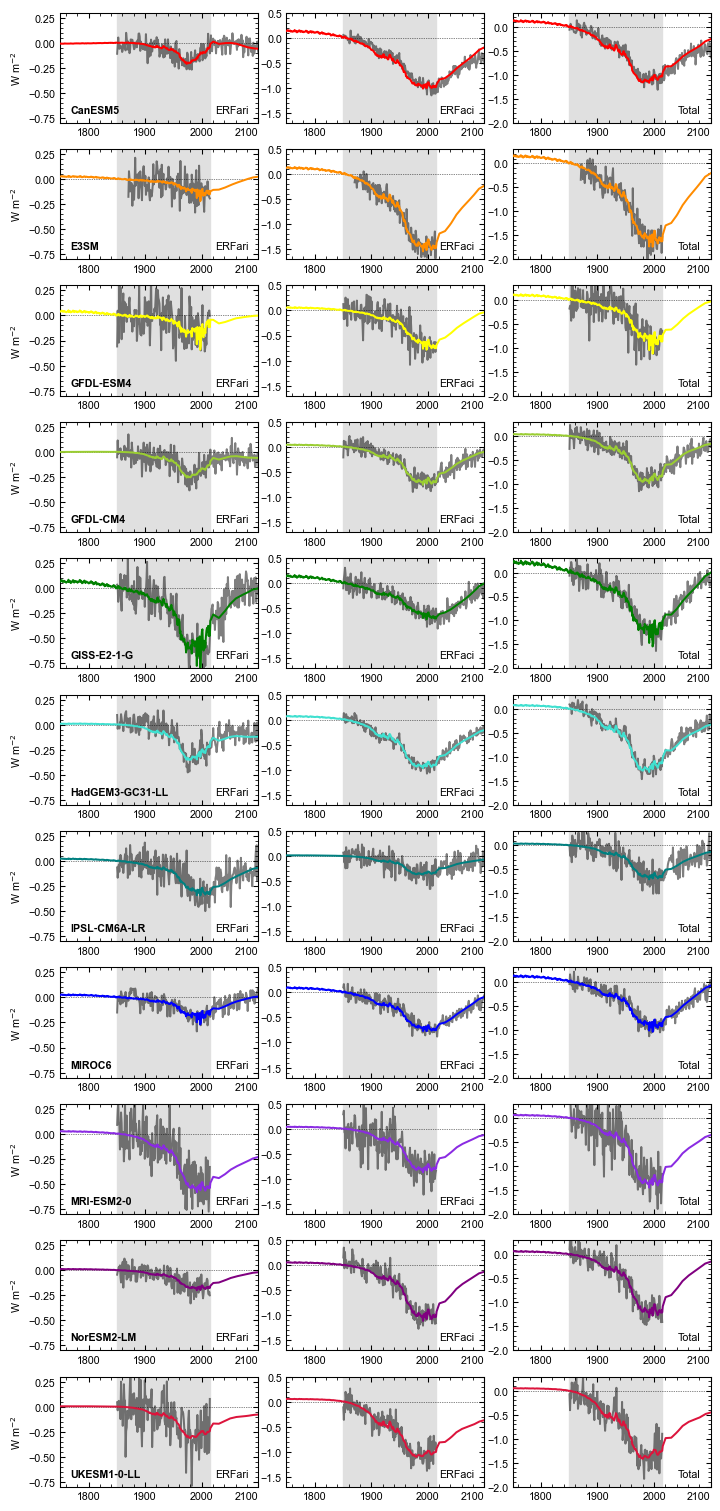

In [18]:
fig, ax = pl.subplots(11,3,figsize=(19/2.54,40/2.54), squeeze=False)
for i, model in enumerate(models):
#    ax[i,0].set_title('%s ERFari' % model)
    ax[i,0].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFariSW'] + cubes[model]['aprp_ERFariLW'], color='k', ls='-', alpha=0.5, label=model)
    ax[i,0].plot(np.arange(1750.5,2101), emulated[model]['ERFari'], color=colors[model], label=model, zorder=7)
#    ax[i,1].set_title('%s ERFaci' % model)
    ax[i,1].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFaciSW']+cubes[model]['aprp_ERFaciLW'], 
                 color='k', ls='-', alpha=0.5)
    ax[i,1].plot(np.arange(1750.5,2101), emulated[model]['ERFaci'], color=colors[model], zorder=7)
#    ax[i,2].set_title('%s aerosol ERF' % models)
    ax[i,2].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFariSW']+cubes[model]['aprp_ERFaciSW']+cubes[model]['aprp_ERFariLW']+cubes[model]['aprp_ERFaciLW'], 
                 color='k', ls='-', alpha=0.5)
    ax[i,2].plot(np.arange(1750.5,2101), emulated[model]['ERFari']+emulated[model]['ERFaci'], color=colors[model], zorder=7)
    ax[i,0].set_xlim(1750,2100)
    ax[i,1].set_xlim(1750,2100)
    ax[i,2].set_xlim(1750,2100)
#    ax[i,0].set_ylabel('Aerosol forcing with respect to 1850 (W m$^{-2}$)')
    ax[i,0].set_ylim(-0.8, 0.3)
    ax[i,1].set_ylim(-1.7, 0.5)
    ax[i,2].set_ylim(-2.0, 0.3)
    ax[i,0].axhline(0, lw=0.5, ls=':', color='k')
    ax[i,1].axhline(0, lw=0.5, ls=':', color='k')
    ax[i,2].axhline(0, lw=0.5, ls=':', color='k')
    ax[i,0].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
    ax[i,1].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
    ax[i,2].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
    ax[i,0].get_xticklabels()[-1].set_ha("right")
    ax[i,1].get_xticklabels()[-1].set_ha("right")
    ax[i,2].get_xticklabels()[-1].set_ha("right")
    #ax[i,0].legend(loc='lower left', frameon=False)
    ax[i,0].text(0.05,0.09,model,transform=ax[i,0].transAxes, fontweight='bold')
    ax[i,0].text(0.95,0.09,'ERFari',transform=ax[i,0].transAxes, ha='right')
    ax[i,1].text(0.95,0.09,'ERFaci',transform=ax[i,1].transAxes, ha='right')
    ax[i,2].text(0.95,0.09,'Total',transform=ax[i,2].transAxes, ha='right')
    ax[i,0].set_ylabel('W m$^{-2}$')

#ax[0,1].set_ylabel('ERFaci with respect to 1850')
#ax[0,0].legend(framealpha=1, loc='lower center', fancybox=False)

#ax[0,0].axvline(2014.5, lw=0.5, color='#c0c0c0')

#ax[0,0].set_xticks(np.arange(1750,2101,50))

#ax[0,1].legend(custom_lines, ['APRP results', 'Emulated fits'], framealpha=1, loc='lower left', fancybox=False)
fig.tight_layout()

In [19]:
so2_samp_ari = np.zeros(len(models))
bc_samp_ari = np.zeros(len(models))
oc_samp_ari = np.zeros(len(models))
nh3_samp_ari = np.zeros(len(models))
log_n0_samp = np.zeros(len(models))
log_n1_samp = np.zeros(len(models))
beta_samp = np.zeros(len(models))

for im, model in enumerate(models):
    print(model)
    print(coeff[model]['ERFari'])
    print(coeff[model]['ERFaci'])
    so2_samp_ari[im] = coeff[model]['ERFari']['SO2']
    bc_samp_ari[im] = coeff[model]['ERFari']['BC']
    oc_samp_ari[im] = coeff[model]['ERFari']['OC']
    nh3_samp_ari[im] = coeff[model]['ERFari']['NH3']
    beta_samp[im] = (coeff[model]['ERFaci']['beta'])
    log_n0_samp[im] = np.log(coeff[model]['ERFaci']['n0'])
    log_n1_samp[im] = np.log(coeff[model]['ERFaci']['n1'])
print()
print('SO2 mean', np.mean(so2_samp_ari))
print('BC mean', np.mean(bc_samp_ari))
print('OC mean', np.mean(oc_samp_ari)) # nice and linear!
print('NH3 mean', np.mean(nh3_samp_ari))
print('SO2 std', np.std(so2_samp_ari))
print('BC std', np.std(bc_samp_ari))
print('OC std', np.std(oc_samp_ari))
print('NH3 std', np.std(nh3_samp_ari))
print()
print('beta mean', np.mean(beta_samp))
print('nSO2 mean', np.mean(log_n0_samp))
print('nPOM mean', np.mean(log_n1_samp))
print('beta std', np.std(beta_samp))
print('log(nSO2) std', np.std(log_n0_samp))
print('log(nPOM) std', np.std(log_n1_samp))
print()

CanESM5
{'BC': 0.0325934448436057, 'OC': -0.00034665350786885785, 'SO2': -0.0024876158908228, 'NH3': -4.589869156619057e-11}
{'beta': 0.7274782427494431, 'n0': 58.95288164936794, 'n1': 24.621709963600736}
E3SM
{'BC': 0.024823188886540854, 'OC': -0.012632190844124477, 'SO2': -0.0009420909814018317, 'NH3': -8.382764963309927e-18}
{'beta': 2.048194761455632, 'n0': 155.8976737215549, 'n1': 71.34288545828805}
GFDL-ESM4
{'BC': 0.10392279516937812, 'OC': -0.029153979808912267, 'SO2': -0.0026789379743594063, 'NH3': -0.0008390122613011199}
{'beta': 5656.599484024968, 'n0': 1669052.8839638059, 'n1': 370189.635619441}
GFDL-CM4
{'BC': 0.028858463532652437, 'OC': -0.002562860380611589, 'SO2': -0.002633891362234049, 'NH3': -5.52164734935872e-05}
{'beta': 3.5014612423789804, 'n0': 692.7308017434415, 'n1': 382.8952742035969}
GISS-E2-1-G
{'BC': 0.14613221426408013, 'OC': -0.04414859990239293, 'SO2': -0.006678277858991499, 'NH3': -1.9859089900200092e-13}
{'beta': 0.5630808726581363, 'n0': 117.9029351955

In [20]:
with open("../data_input/cmip6_aerosol_coefficients.json", "w") as write_file:
    json.dump(coeff, write_file, indent=4)

In [21]:
erfaci = np.zeros(11)
for i, model in enumerate(models):
    erfaci[i] = np.mean(cubes[model]['aprp_ERFaciSW'][155:166]+cubes[model]['aprp_ERFaciLW'][155:166])

In [22]:
pd.DataFrame(np.corrcoef([erfaci, log_n0_samp, log_n1_samp, so2_samp_ari, bc_samp_ari, oc_samp_ari, nh3_samp_ari]))

,0,1,2,3,4,5,6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.000000,0.962910,0.208370,0.111885,-0.169684,-0.106880
2,NaN,0.962910,1.000000,0.324409,-0.086340,0.022477,-0.159775
3,NaN,0.208370,0.324409,1.000000,-0.772127,0.670745,0.143058
4,NaN,0.111885,-0.086340,-0.772127,1.000000,-0.931603,0.148770
5,NaN,-0.169684,0.022477,0.670745,-0.931603,1.000000,-0.115366
6,NaN,-0.106880,-0.159775,0.143058,0.148770,-0.115366,1.000000


In [23]:
np.corrcoef([so2_samp_ari, bc_samp_ari, oc_samp_ari, nh3_samp_ari])

array([[ 1.        , -0.77212696,  0.6707448 ,  0.14305777],
       [-0.77212696,  1.        , -0.93160252,  0.14877035],
       [ 0.6707448 , -0.93160252,  1.        , -0.11536617],
       [ 0.14305777,  0.14877035, -0.11536617,  1.        ]])

In [24]:
kde = gaussian_kde([log_n0_samp, log_n1_samp])
aci_sample=kde.resample(size=SAMPLES, seed=63648708)
kde = gaussian_kde([so2_samp_ari, bc_samp_ari, oc_samp_ari, nh3_samp_ari])
ari_sample=kde.resample(size=SAMPLES, seed=685534562)

In [25]:
df = pd.DataFrame(aci_sample.T, columns=['log(n_SO2)', 'log(n_POM)'])
df.to_csv('../data_input_large/ERFaci_samples.csv', index=False)

df = pd.DataFrame(ari_sample.T, columns=['SO2', 'BC', 'OC', 'NH3'])
df.to_csv('../data_input_large/ERFari_samples.csv', index=False)

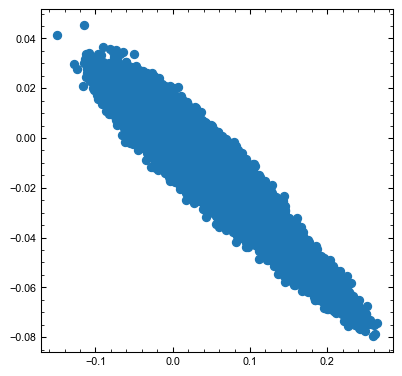

In [26]:
pl.scatter(ari_sample[1,:], ari_sample[2,:])

In [27]:
print(coeff['mean']['ERFari'])
print(coeff['mean']['ERFaci'])

{'BC': 0.03327935622176563, 'OC': -0.009422073461822255, 'SO2': -0.0026417947224789983, 'NH3': -0.0004767775960356343}
{'beta': 1.2005530115741825, 'n0': 154.26840962751257, 'n1': 76.29689490142864}


In [28]:
emulator = np.zeros((351,11))
for i, model in enumerate(models):
    emulator[:,i] = emulated[model]['ERFari']+emulated[model]['ERFaci']
df = pd.DataFrame(emulator, columns=models)
df['year'] = np.arange(1750,2101)
df.set_index('year', inplace=True)
df.to_csv('../data_output/ERFaer_model_emulations.csv')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


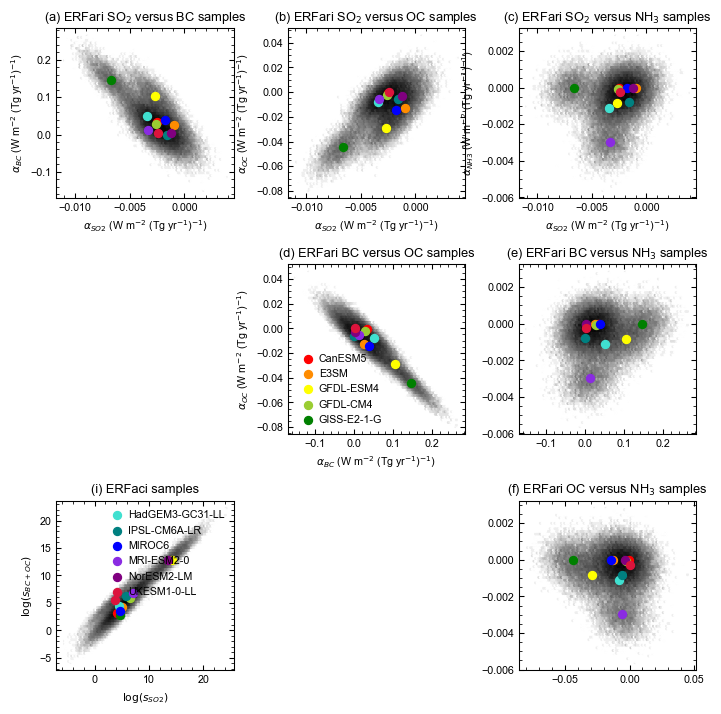

In [29]:
fig = pl.figure(figsize=(19/2.54,19/2.54))

ax = fig.add_subplot(331)
ax.hexbin(ari_sample[0,:], ari_sample[1,:], cmap='Greys',  bins='log')
ax.set_xlabel(r'$\alpha_{SO2}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
ax.set_ylabel(r'$\alpha_{BC}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
for model in models:
    ax.scatter(coeff[model]['ERFari']['SO2'], coeff[model]['ERFari']['BC'], color=colors[model], label=model, alpha=1)
ax.set_title('(a) ERFari SO$_2$ versus BC samples')

ax = fig.add_subplot(332)
ax.hexbin(ari_sample[0,:], ari_sample[2,:], cmap='Greys',  bins='log')
ax.set_xlabel(r'$\alpha_{SO2}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
ax.set_ylabel(r'$\alpha_{OC}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
for model in models:
    ax.scatter(coeff[model]['ERFari']['SO2'], coeff[model]['ERFari']['OC'], color=colors[model], label=model, alpha=1)
ax.set_title('(b) ERFari SO$_2$ versus OC samples')

ax = fig.add_subplot(333)
ax.hexbin(ari_sample[0,:], ari_sample[3,:], cmap='Greys',  bins='log')
ax.set_xlabel(r'$\alpha_{SO2}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
ax.set_ylabel(r'$\alpha_{NH3}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
for model in models:
    ax.scatter(coeff[model]['ERFari']['SO2'], coeff[model]['ERFari']['NH3'], color=colors[model], label=model, alpha=1)
ax.set_title('(c) ERFari SO$_2$ versus NH$_3$ samples')

ax = fig.add_subplot(335)
ax.hexbin(ari_sample[1,:], ari_sample[2,:], cmap='Greys',  bins='log')
for i, model in enumerate(models):
    if i<5:
        label = model
    else:
        label = ''
    ax.scatter(coeff[model]['ERFari']['BC'], coeff[model]['ERFari']['OC'], color=colors[model], label=label, alpha=1)
ax.set_title('(d) ERFari BC versus OC samples')
ax.set_xlabel(r'$\alpha_{BC}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
ax.set_ylabel(r'$\alpha_{OC}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
ax.legend(frameon=False, handletextpad=0.02)

ax = fig.add_subplot(336)
ax.hexbin(ari_sample[1,:], ari_sample[3,:], cmap='Greys',  bins='log')
for i, model in enumerate(models):
    ax.scatter(coeff[model]['ERFari']['BC'], coeff[model]['ERFari']['NH3'], color=colors[model], label=label, alpha=1)
ax.set_title('(e) ERFari BC versus NH$_3$ samples')
ax.legend(frameon=False, handletextpad=0.02)

ax = fig.add_subplot(339)
ax.hexbin(ari_sample[2,:], ari_sample[3,:], cmap='Greys',  bins='log')
for i, model in enumerate(models):
    ax.scatter(coeff[model]['ERFari']['OC'], coeff[model]['ERFari']['NH3'], color=colors[model], label=label, alpha=1)
ax.set_title('(f) ERFari OC versus NH$_3$ samples')
ax.legend(frameon=False, handletextpad=0.02)

ax = fig.add_subplot(337)
ax.hexbin(aci_sample[0,:],aci_sample[1,:], cmap='Greys',  bins='log')
ax.set_xlabel(r'$\log(s_{SO2})$')
ax.set_ylabel(r'$\log(s_{BC+OC})$')
for i, model in enumerate(models):
    if i<5:
        label = ''
    else:
        label = model
    ax.scatter(np.log(coeff[model]['ERFaci']['n0']), np.log(coeff[model]['ERFaci']['n1']), color=colors[model], label=label)
ax.set_title('(i) ERFaci samples')
ax.legend(frameon=False, handletextpad=0.02)

fig.tight_layout()
pl.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)